# 5. Multimodal characterization of exRNA environment

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import spatialdata as sd
from tqdm import tqdm

/home/sergio/.local/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_text from `anndata` is deprecated. Import anndata.io.read_text instead.
  warnings.warn(msg, FutureWarning)


In [62]:
xenium_path_cropped = "/media/sergio/Discovair_final/mousebrain_prime_crop_points2regions_annotated.zarr"
output_path = "/media/sergio/Discovair_final/analysis_crop"
sdata = sd.read_zarr(xenium_path_cropped)

/home/sergio/.local/lib/python3.10/site-packages/zarr/creation.py:614: UserWarning: ignoring keyword argument 'read_only'
  compressor, fill_value = _kwargs_compat(compressor, fill_value, kwargs)
/home/sergio/.local/lib/python3.10/site-packages/zarr/creation.py:614: UserWarning: ignoring keyword argument 'read_only'
  compressor, fill_value = _kwargs_compat(compressor, fill_value, kwargs)
/home/sergio/.local/lib/python3.10/site-packages/zarr/creation.py:614: UserWarning: ignoring keyword argument 'read_only'
  compressor, fill_value = _kwargs_compat(compressor, fill_value, kwargs)
/home/sergio/.local/lib/python3.10/site-packages/zarr/creation.py:614: UserWarning: ignoring keyword argument 'read_only'
  compressor, fill_value = _kwargs_compat(compressor, fill_value, kwargs)
/home/sergio/.local/lib/python3.10/site-packages/zarr/creation.py:614: UserWarning: ignoring keyword argument 'read_only'
  compressor, fill_value = _kwargs_compat(compressor, fill_value, kwargs)
/home/sergio/.local/

In [63]:
imarray = sdata.images["morphology_focus"]["scale0"].image.compute()
chnames = list(sdata.images["morphology_focus"]["scale0"].image.c.values)
transcripts = sdata.points["extracellular_transcripts_enriched"].compute()

minx = transcripts.x.min()
maxx = transcripts.x.max()
transcripts_size_x = maxx - minx
image_size_x = imarray.shape[2]
multi_factor_x = image_size_x / transcripts_size_x

miny = transcripts.y.min()
maxy = transcripts.y.max()
transcripts_size_y = maxy - miny
image_size_y = imarray.shape[1]
multi_factor_y = image_size_y / transcripts_size_y

transcripts["x_scaled"] = (transcripts["x"] - minx) * multi_factor_x
transcripts["y_scaled"] = (transcripts["y"] - miny) * multi_factor_y

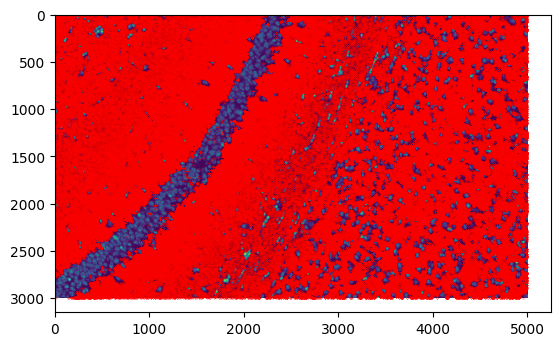

In [64]:
plt.imshow(imarray[0, :, :])
plt.scatter(transcripts.x_scaled, transcripts.y_scaled, s=0.01, color="red")

In [ ]:
import numpy as np
from scipy.ndimage import gaussian_filter, zoom


# Example: Assuming `data_array` is your xArray DataArray with dims (channels, height, width)
def process_xarray(data_array, sigma=5, downsize_factor=0.1):
    """
    Processes a 3D xarray by applying Gaussian smoothing and downscaling on each 2D slice.

    Parameters
    ----------
    - data_array: xarray.DataArray
        A 3D xarray where the first dimension represents slices, and the next two dimensions
        represent 2D spatial data.
    - sigma: float, optional (default=5)
        The standard deviation for the Gaussian kernel used in smoothing.
    - downsize_factor: float, optional (default=0.1)
        The factor by which each 2D slice is resized during downscaling.

    Returns
    -------
    - smoothed_and_downsized: numpy.ndarray
        A 3D numpy array with processed slices, where the first dimension corresponds to
        the original slicing dimension, and the remaining dimensions are the downsized
        2D spatial data.

    Notes
    -----
    - The function loops through each slice of the input data, applies Gaussian smoothing,
      downsizes the smoothed array, and stacks the results back into a single 3D array.
    - Ensure that `data_array` has the correct shape and data types for processing.
    """
    processed_slices = []

    for i in range(data_array.shape[0]):  # Loop over the first dimension
        slice_2d = data_array[i, :, :].values  # Extract the 2D slice

        # Apply KDE (Gaussian smoothing)
        smoothed = gaussian_filter(slice_2d, sigma=sigma)

        # Downsize the array
        downscaled = zoom(smoothed, downsize_factor)

        processed_slices.append(downscaled)

    smoothed_and_downsized = np.stack(processed_slices, axis=0)
    return smoothed_and_downsized


# Example usage
# Assuming your xArray is named `image_array`
smoothed_and_downsized = process_xarray(imarray, sigma=5, downsize_factor=0.5)

# Check the new shape
print(smoothed_and_downsized.shape)

(5, 1500, 2500)


# Continue analysis

In [ ]:
allg = []
for indi in tqdm(transcripts.index):
    allg.append(imarray[:, int(transcripts.loc[indi, "y_scaled"]) - 1, int(transcripts.loc[indi, "x_scaled"]) - 1])

100%|██████████| 703261/703261 [01:54<00:00, 6168.38it/s]


In [68]:
from tqdm import tqdm

# Initialize a list to hold the pixel intensities for all transcripts
allg = []

for indi in tqdm(transcripts.index):
    # Get the x and y coordinates from the DataFrame
    y_coord = int(transcripts.loc[indi, "y_scaled"])
    x_coord = int(transcripts.loc[indi, "x_scaled"])

    # Ensure coordinates are within the bounds of the image array
    if 0 <= y_coord < imarray.shape[1] and 0 <= x_coord < imarray.shape[2]:
        # Extract the pixel intensity for all channels at the given coordinates
        pixel_values = imarray[:, y_coord, x_coord]  # Extract for all channels
        allg.append(pixel_values)
    else:
        # Handle out-of-bound coordinates, if needed
        allg.append([np.nan] * imarray.shape[0])  # Create a list of NaNs for each channel

# Convert the list of pixel intensities into a NumPy array for easier manipulation
pixel_intensities = np.array(allg)

# Add each channel's pixel intensity as a separate column in the transcripts DataFrame
for i in range(pixel_intensities.shape[1]):  # Iterate over the number of channels
    transcripts[chnames[i]] = pixel_intensities[:, i]

# The transcripts DataFrame now has a column for each channel's intensity

100%|██████████| 703261/703261 [01:56<00:00, 6021.10it/s]


In [ ]:
tran2 = transcripts.loc[:, chnames + ["feature_name"]]
tran2["feature_name"] = tran2["feature_name"].astype(str)
mean_intensity = tran2.groupby("feature_name").mean()

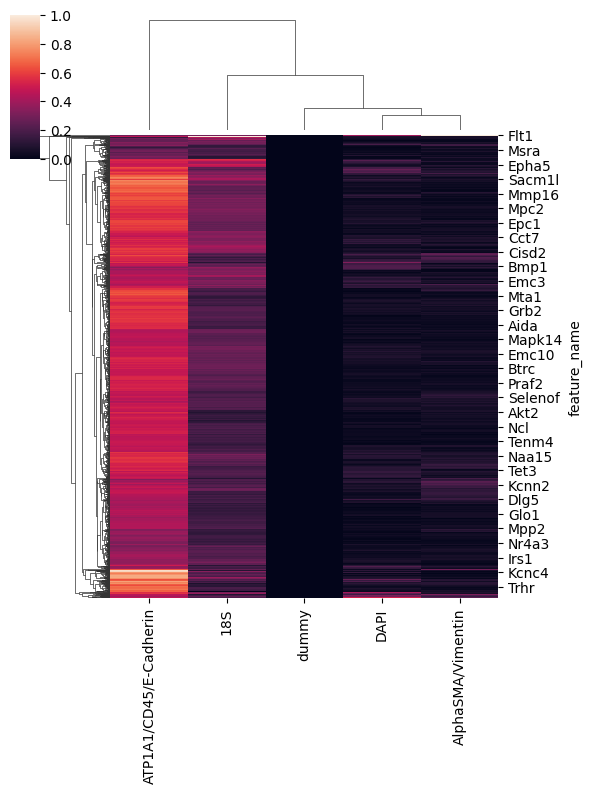

In [84]:
## turn into plotting
mean_intensity_norm = mean_intensity.subtract(mean_intensity.min(axis=0), axis=1)
mean_intensity_norm = mean_intensity_norm.div(mean_intensity_norm.max(axis=0), axis=1)
sns.clustermap(mean_intensity_norm.fillna(0).astype(float), figsize=(6, 8))

<Axes: xlabel='ATP1A1/CD45/E-Cadherin', ylabel='feature_name'>

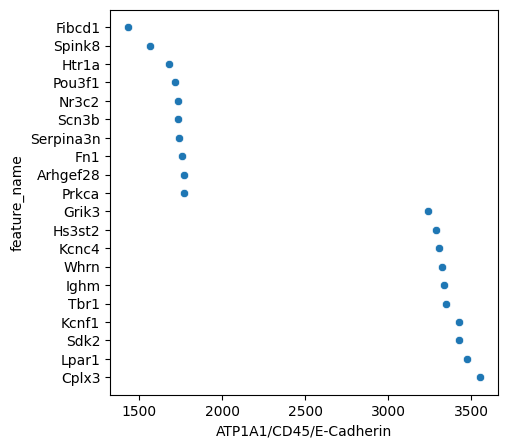

In [94]:
selection = "ATP1A1/CD45/E-Cadherin"
mean_intensity_sorted = mean_intensity.sort_values(by=selection)
intensity_edges = pd.concat([mean_intensity_sorted.head(10), mean_intensity_sorted.tail(10)])
plt.figure(figsize=(5, 5))
sns.scatterplot(y=intensity_edges.index, x=intensity_edges[selection])

<Axes: xlabel='AlphaSMA/Vimentin', ylabel='feature_name'>

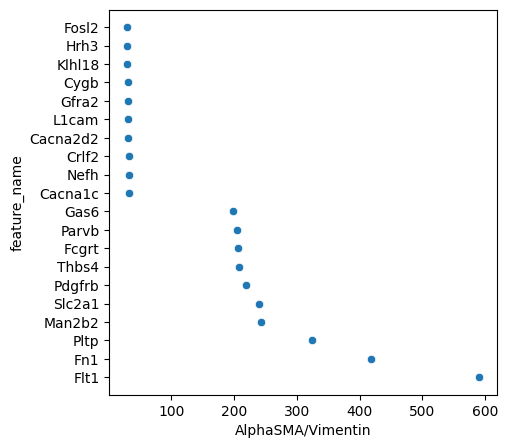

In [95]:
selection = "AlphaSMA/Vimentin"
mean_intensity_sorted = mean_intensity.sort_values(by=selection)
intensity_edges = pd.concat([mean_intensity_sorted.head(10), mean_intensity_sorted.tail(10)])
plt.figure(figsize=(5, 5))
sns.scatterplot(y=intensity_edges.index, x=intensity_edges[selection])